# Train a Cellpose model from scratch with a pre-trained encoder

This example shows how to use `cellseg_models.pytorch` for training a [Cellpose](https://www.nature.com/articles/s41592-020-01018-x) model for instance segmentation with pytorch lightning along with the datasets and tools provided by the library.

In [1]:
# !pip install cellseg-models-pytorch[all]

## Download data

First, we will download nuclei segmentation data. We will use the [Lizard](hhttp://arxiv.org/abs/2108.11195) dataset by Graham et al. The Lizard dataset is split into three folds. We will use the first fold as training data, second as validation and the third as testing data. Furthermore, the images of the Lizard dataset are too big to be used as input directly, thus, we will patch the images and label masks into overlapping patches of size 320x320px. 

Since we will train the [Cellpose](https://github.com/stardist/stardist) model, we need to define the right nuclei instance transformations for training time. For Cellpose, we just need to define `"cellpose"` transformation. The `"cellpose"` transforms the labelled instance masks into x- and y- gradient flows of the instances with a time-independent heat diffusion algorithm.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"minmax"` normalization for the input images.

NOTE: The processing of the dataset will take some time, so go ahead and go get yourself a coffee while waiting.

In [3]:
import pytorch_lightning as pl
import cellseg_models_pytorch as csmp
from pathlib import Path
from cellseg_models_pytorch.datamodules import LizardDataModule

fold_split = {"train": 1, "valid": 2, "test": 3}
save_dir = Path.home() / "lizard" # modify the save path
lizard_module = LizardDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["cellpose"],
    img_transforms=["blur", "hue_sat"],
    patch_size=(320, 320),
    stride=220,
    normalization="minmax",
)

lizard_module.prepare_data() # download and process the lizard data

Found no data or an incomplete dataset. Downloading the whole thing...


100%|██████████| 319M/319M [00:23<00:00, 13.4MiB/s] 
100%|██████████| 263M/263M [00:18<00:00, 14.1MiB/s] 
100%|██████████| 26.1M/26.1M [00:02<00:00, 9.51MiB/s]


Splitting the files into train, valid, and test sets.
Patch the data... This will take a while...


Extracting test patches to folders..: 100%|██████████| 98/98 [10:25<00:00,  6.38s/it, # of extracted tiles 2627]


**Visualize a couple samples form the training data**

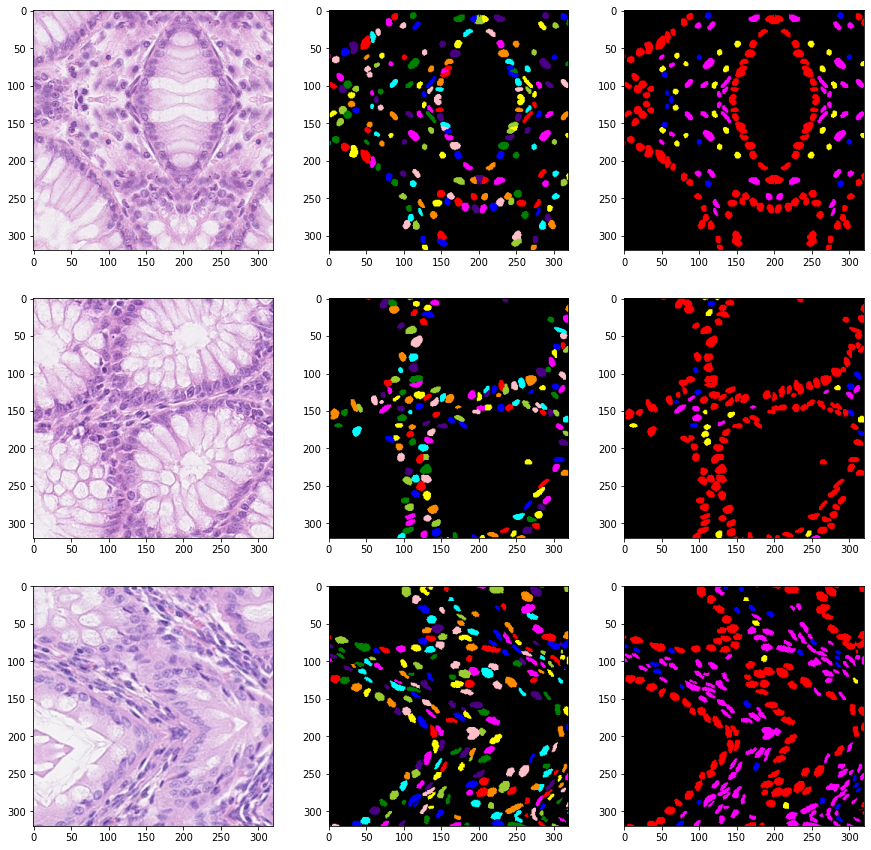

In [6]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb

img_dir = save_dir / "train" / "train_im_patches"
mask_dir = save_dir / "train" / "train_mask_patches"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

im1 = csmp.utils.FileHandler.read_img(imgs[0])
im2 = csmp.utils.FileHandler.read_img(imgs[50])
im3 = csmp.utils.FileHandler.read_img(imgs[300])
mask1 = csmp.utils.FileHandler.read_mask(masks[0], return_all=True)
mask2 = csmp.utils.FileHandler.read_mask(masks[50], return_all=True)
mask3 = csmp.utils.FileHandler.read_mask(masks[300], return_all=True)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(im2)
ax[4].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[5].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[6].imshow(im3)
ax[7].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[8].imshow(label2rgb(mask3["type_map"], bg_label=0))

## Training

First, we define the cellpose model. In this example we will use an efficient-net-v2 (small variant) encoder from the [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) library with imagenet pre-trained weights (trained with tensorflow).

In [2]:
model = csmp.models.cellpose_base(
    enc_name="tf_efficientnetv2_s",
    type_classes=len(lizard_module.type_classes),
)

Next, we will define a `SegmentationExperiment`. It is a `pytorch.LightningModule` wrapper that encapsulates everything needed for training the model.

We'll set the loss for the `cellpose` head to be MSE-SSIM joint-loss and for the type head, a joint-loss of Tversky-Focal loss. We also monitor the mIoU metric for the type head output.

This time, the optimizer used will be [AdamW](https://arxiv.org/abs/1711.05101).

In [3]:
from cellseg_models_pytorch.training.lit import SegmentationExperiment

# We will be monitoring for the mIoU score of the type maps.
# for each output, we will define separate joint-losses.
experiment = SegmentationExperiment(
    model=model,
    branch_losses={"cellpose": "ssim_mse", "type": "tversky_focal"},
    branch_metrics={"cellpose": [None], "type": ["miou"]},
    optimizer="adamw",
)

# Lightning training
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    move_metrics_to_cpu=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
# Train the model
trainer.fit(model=experiment, datamodule=lizard_module)

Found all folds. Skip downloading.
Found splitted Lizard data. If in need of a re-download, please empty the `save_dir` folder.
Found processed Lizard data. If in need of a re-process, please empty the `save_dir` folders.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | model         | CellPoseUnet  | 23.5 M
1 | criterion     | MultiTaskLoss | 0     
2 | train_metrics | ModuleDict    | 0     
3 | val_metrics   | ModuleDict    | 0     
4 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
93.922    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 651/651 [06:31<00:00,  1.66it/s, loss=0.335, v_num=7, train_loss=0.241, train_type=0.537]


Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `csmp.inference` module.

Here, we will be using a sliding window method for inference (`SlidingWindowInferer`), since the input images are too big for the model. The sliding window inferer uses overlapping patches of the input image and averages the model outputs of those patches to form a segmentation mask of the original size.

 The `Inferers` take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, ofc, we will use `cellpose` post-processing.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the prediction of the image. This can only be useful when inference is run for bigger images that are patched in overlapping patches (this can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 3 first images of inside the input folder.
- `batch_size` -This needs to be set to 1 since the input images have different sizes and the dataloader can't stack them.

In [5]:
inferer = csmp.inference.SlidingWindowInferer(
    model=experiment,
    input_folder=save_dir / "valid" / "images",
    out_activations={"cellpose": None, "type": "softmax"},
    out_boundary_weights={"cellpose": True, "type": False},
    padding=80,
    stride=220,
    patch_size=(320, 320),
    instance_postproc="cellpose",
    normalization="minmax", # same normalization as during training
    batch_size=1, # Set to 1 since input images have different shapes
    n_images=3, # Use only the 3 first images of the folder
)
inferer.infer()

Running inference: 100%|██████████| 3/3 [00:26<00:00,  8.68s/batch, post-processing]


**Let's plot the first result**

With only 10 epochs of training, we're already getting descent results. Ofc, there is room for improvement since a lot of cells are missed but you get the idea

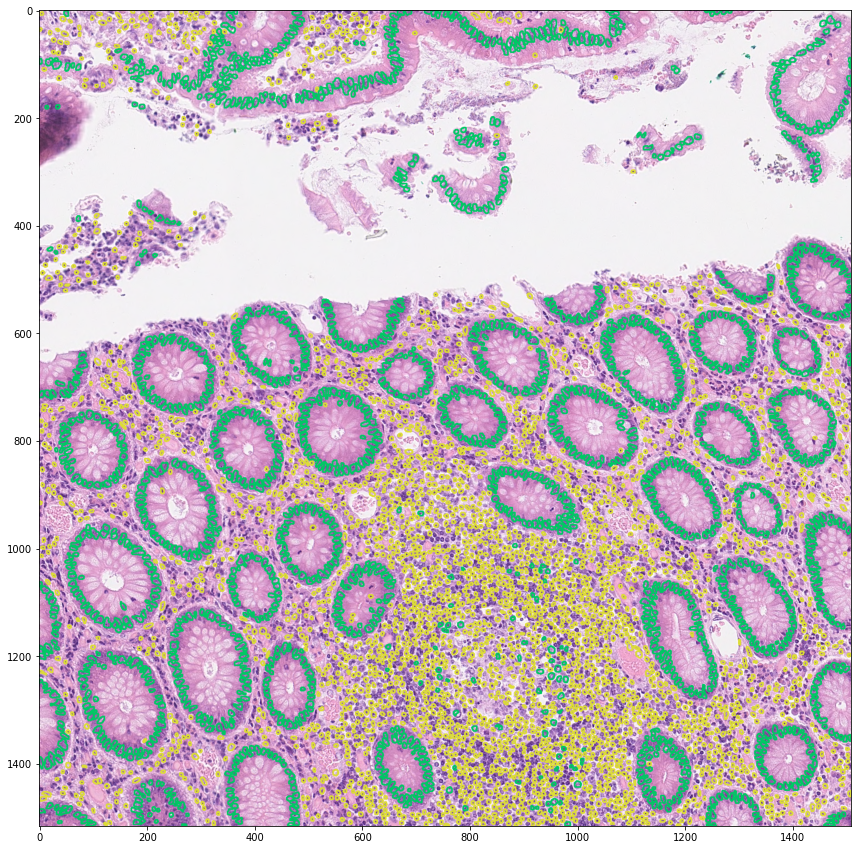

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

samples = list(inferer.out_masks.keys())
masks = inferer.out_masks[samples[0]]

img_path = save_dir / "valid" / f"images/{samples[0]}.png"
img = csmp.utils.FileHandler.read_img(img_path)
cont = csmp.utils.draw_thing_contours(masks["inst"], img, masks["type"])
ax.imshow(cont)